> Ice [-5,:] means ice condition during Aug in the last model year.

> Ice [-1,:] means ice condition in Dec in the last model year.

> The comparison is made in summer time. (because that is when the measurement is taken.)

In [37]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import pandas as pd
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.cm as cm
% matplotlib inline

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/total/T*.csv'))
print("found *.csv file: \n{}".format(nc_filename))

filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/*T200201-200712*.nc'))
ptrc=nc.Dataset(filename[0])
nav_lon=ptrc.variables['nav_lon'][:]
nav_lat=ptrc.variables['nav_lat'][:]
dep = ptrc.variables['deptht'][:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

found *.csv file: 
['/ocean/xiaoxiny/research/data/total/Total_r1.csv', '/ocean/xiaoxiny/research/data/total/Total_r2.csv', '/ocean/xiaoxiny/research/data/total/Total_r3.csv', '/ocean/xiaoxiny/research/data/total/Total_r4.csv', '/ocean/xiaoxiny/research/data/total/Total_r5.csv', '/ocean/xiaoxiny/research/data/total/Total_r6.csv']


In [38]:
def readdata(phase,string,i,a1,a2,b1,b2):
    if string =='Pa':
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_7'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_7'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_9'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_9'][:,i,a1:a2,b1:b2]
    else:
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_8'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_8'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_10'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_10'][:,i,a1:a2,b1:b2]
    data=np.ma.masked_where(data<=0,data)
    return data

In [39]:
maske=ptrc.variables['TR_7'][:]
def readice(string,i,x,y):
    if i ==0:
        if string =='Pa':
                data=ptrc.variables['TR_11'][:,:,x,y]
        else:
                data=ptrc.variables['TR_12'][:,:,x,y]
        data=np.ma.masked_where(maske[:,:,x,y]<=0,data)
    else:
        if string =='Pa':
                data=ptrc.variables['TR_11'][:,i,x,y]
        else:
                data=ptrc.variables['TR_12'][:,i,x,y]
        data=np.ma.masked_where(maske[:,i,x,y]<=0,data)
    if string =='deso':
        Dsopt=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/data_Th_desorption_rate.nc')
        data=Dsopt.variables['desorption_rate'][:,x,y]
    
    return data

def analy(string,phase,i,a,b,ice):
        if string=='Pa':
            k=-0.0005*100*ice[i]+0.06
            if phase=='part':
                    analy=0.00246/(6.01*100*ice[i]+500)*dep[i]                    
            else:
                analy=0.00246/k+0.31/k*0.00246/(6.01*100*ice[i]+500)*dep[i]
        if string=='Th':
            k=-0.0067*100*ice[i]+0.75
            if phase=='part':
                analy=0.0267/(2.26*100*ice[i]+500)*dep[i]
            else:
                k_1=readice('deso',i,a,b)
                analy=0.0267/k+k_1/k*0.0267/(2.26*100*ice[i]+500)*dep[i]
        
        return analy

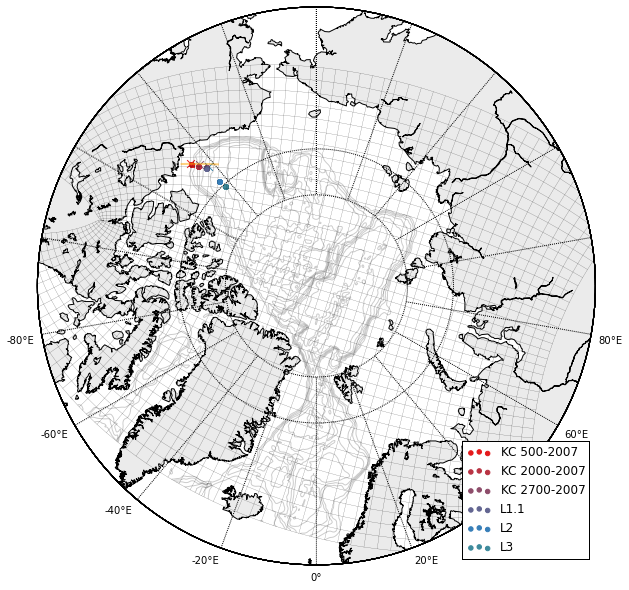

In [40]:
ax = plt.figure(1,figsize=(10,10))
ax = plt.subplot()
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round='True')

for j in range(len(nc_filename)):
    data=pd.read_csv(nc_filename[j])
    y=data['230Th tot.'];
    lon = data['long.'];
    lat = data['lat.'];
    name= data['name'][0];
    #print("found *.csv file: \n{}".format(data))

    lon=np.ma.masked_where(y<=0,lon)
    lat=np.ma.masked_where(y<=0,lat) 

    lon=lon.compressed()
    lat=lat.compressed()
    
    if len(lon)!=0:
        
        ax.hold(True)        
        y_lon, yy_lat = m(lon, lat)
        m.scatter(y_lon,yy_lat,color=cm.Set1(j*8),label=name)
    
    if j==0:
        m.drawcoastlines()
        m.fillcontinents(color = '0.85',alpha=0.5)
        m.drawparallels(np.arange(-90.,90.,15.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon, y_lat = m(nav_lon[:], nav_lat[:])
        m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon[::10,::10].T,y_lat[::10,::10].T,color='black',linewidth=0.2,alpha=0.7)
        m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.2)
        m.plot(x_lon[303,140:180],y_lat[303,140:180],lw=2,color='orange',alpha=0.5)
        m.scatter(x_lon[303,150],y_lat[303,150],color=cm.Set1(0*18),marker='x',s=60)
        m.scatter(x_lon[302,160],y_lat[302,160],color=cm.Set1(1*18),marker='x',s=60)
        m.scatter(x_lon[300,170],y_lat[300,170],color=cm.Set1(2*18),marker='x',s=60)
plt.legend(loc=4)
plt.show()

# 231Pa

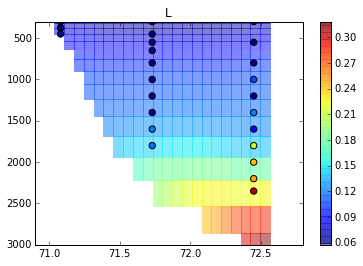

In [41]:
# ax = plt.figure(1,figsize=(8,5))

lmin=0#25
lmax=46
data0=readdata('diss','Pa',i=0,a1=303,a2=304,b1=150,b2=175)\
    +readdata('part','Pa',i=0,a1=303,a2=304,b1=150,b2=175)
data_=data0[-5,lmin:lmax,0,:]
plt.pcolor(nav_lat[303,150:175],dep[lmin:lmax],data_,alpha=0.5)
plt.colorbar()

for j in range(len(nc_filename)):
    data=pd.read_csv(nc_filename[j])
    y= data['depth'].values;
    x=data['231 tot.'].values;
    lon = data['long.'].values;
    lat = data['lat.'].values;
    name= data['name'][0];
    
    y_=[];x_=[];lon_=[];lat_=[];
    for i in range (len(x)):
        if x[i]>=0:
            y_.append(y[i]);x_.append(x[i])
            lon_.append(lon[i]);lat_.append(lat[i])
    
    if len(lon_)!=0:
        plt.scatter(lat_,y_,c=x_,vmin=np.min(data_),vmax=np.max(data_),s=40)
plt.xlim([70.9,72.8]);plt.ylim([300,3000]);plt.gca().invert_yaxis();plt.title('%s'%(name[0]))
plt.show()

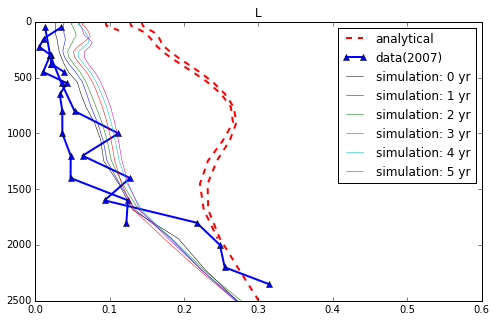

In [42]:
xloc=[303,302,300]
yloc=[150,160,170]

ax = plt.figure(1,figsize=(8,5))
temp=0
for k in range (len(xloc)):   
    ice=readice('Pa',i=0,x=xloc[k],y=yloc[k])
    ana=np.zeros(len(data0[0,:,0,0]))
    for z in range (len(data0[0,:,0,0])):
        ana[z]   =analy('Pa','diss',i=z,a=xloc[k],b=yloc[k],ice=ice[-5,:])\
                 +analy('Pa','part',i=z,a=xloc[k],b=yloc[k],ice=ice[-5,:])
    ana=np.ma.masked_where(np.ma.getmask(ice[-5,:]),ana)
    if temp==0:
        plt.plot(ana,dep,'--',lw=2,c='red',label='analytical')
        temp=1
    else:
        plt.plot(ana,dep,'--',lw=2,c='red')#,label='analytical')

for j in range(len(nc_filename)):
    data=pd.read_csv(nc_filename[j])
    y= data['depth'].values;
    x=data['231 tot.'].values;
    lon = data['long.'].values;
    lat = data['lat.'].values;
    #name= data['name'][0];
    y_=[];x_=[];lon_=[];lat_=[];
    for i in range (len(x)):
        if x[i]>=0:
            y_.append(y[i]);x_.append(x[i])
            lon_.append(lon[i]);lat_.append(lat[i])
    if j<3 and len(lon_)!=0:
        if j ==0:
            plt.plot(x_,y_,'-^',lw=2,c='blue',label='data(2007)')
        else:
            plt.plot(x_,y_,'-^',lw=2,c='blue')#,label='data(2007)')
    if j>=3 and len(lon_)!=0:
        if j==3:
            plt.plot(x_,y_,'-.',lw=2,c='blue',label='data(2009)',alpha=0.2) 
        else:
            plt.plot(x_,y_,'-.',lw=2,c='blue',alpha=0.2)#,label='data(2009)') 


for i in range (8,len(data0[:,0,0,0]),12):
    plt.plot(data0[i,lmin:lmax,0,yloc[k]-150],dep[lmin:lmax],lw=0.5,label='simulation: %s yr'%((i-8)/12))

plt.ylim([0,2500])
plt.gca().invert_yaxis()
plt.title('%s'%(name[0]))
plt.legend()
plt.show()

```
part. =  Q/s*z  
(Th: s=226*ice + 500)

diss. =  Q/k+ k_1/k*part.

analy. solution (diss+part) is too high  --> k and/or s might be too low, k_1 might be too high

```

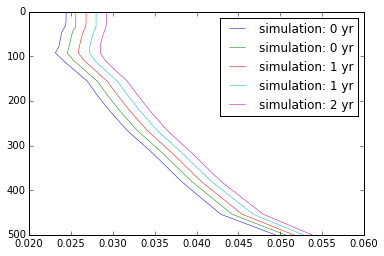

In [36]:
# plot Noadv or diff. scheme (check our scavending model.)
# Figure above shows some crossings in the first 500 meter, which is not consistent with our expectation.
# This cell shows the result in the first 500m in the absence of advection and diffusion.
# The result indicates our scavenging model itself is doing well. It's trying to match the red dash lines above.

xloc=[303,302,300]
yloc=[150,160,170]

ptrc=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/subset_[Noadv_1m_20020101_20041231_ptrc_T.nc].nc')
lmin=0#25;
lmax=46
data0=readdata('diss','Pa',i=0,a1=303,a2=304,b1=150,b2=175)\
    +readdata('part','Pa',i=0,a1=303,a2=304,b1=150,b2=175)
data_=data0[-5,lmin:lmax,0,:]
for i in range (8,len(data0[:,0,0,0]),6):
    plt.plot(data0[i,lmin:lmax,0,yloc[k]-150],dep[lmin:lmax],lw=0.5,label='simulation: %s yr'%((i-8)/12))

plt.ylim([0,500])
plt.xlim([0.02,0.06])
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Back to our evaluation:

# 230Th

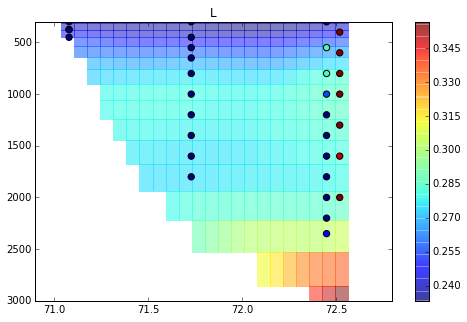

In [7]:
ax = plt.figure(1,figsize=(8,5))

lmin=25
lmax=46
data0=readdata('diss','Th',i=0,a1=303,a2=304,b1=150,b2=175)\
    +readdata('part','Th',i=0,a1=303,a2=304,b1=150,b2=175)
data_=data0[-5,lmin:lmax,0,:]
plt.pcolor(nav_lat[303,150:175],dep[lmin:lmax],data_,alpha=0.5)
plt.colorbar()

for j in range(len(nc_filename)):
    data=pd.read_csv(nc_filename[j])
    y= data['depth'].values;
    x=data['230Th tot.'].values;
    lon = data['long.'].values;
    lat = data['lat.'].values;
    name= data['name'][0];
    
    y_=[];x_=[];lon_=[];lat_=[];
    for i in range (len(x)):
        if x[i]>=0:
            y_.append(y[i]);x_.append(x[i])
            lon_.append(lon[i]);lat_.append(lat[i])
    
    if len(lon_)!=0:
        plt.scatter(lat_,y_,c=x_,vmin=np.min(data_),vmax=np.max(data_),s=40)
plt.xlim([70.9,72.8]);plt.ylim([300,3000]);plt.gca().invert_yaxis();plt.title('%s'%(name[0]))
plt.show()

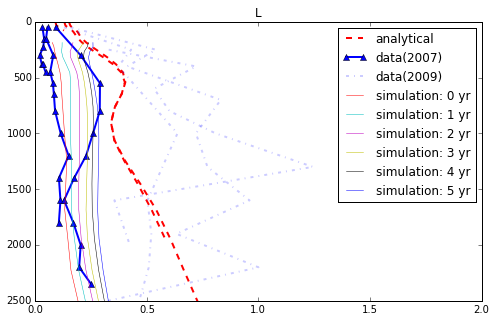

In [8]:
xloc=[303,302,300]
yloc=[150,160,170]

ax = plt.figure(1,figsize=(8,5))
temp=0
for k in range (len(xloc)):   
    ice=readice('Th',i=0,x=xloc[k],y=yloc[k])
    ana=np.zeros(len(data0[0,:,0,0]))
    for z in range (len(data0[0,:,0,0])):
        ana[z]   =analy('Th','diss',i=z,a=xloc[k],b=yloc[k],ice=ice[-5,:])\
                 +analy('Th','part',i=z,a=xloc[k],b=yloc[k],ice=ice[-5,:])
    ana=np.ma.masked_where(np.ma.getmask(ice[-5,:]),ana)
    if temp==0:
        plt.plot(ana,dep,'--',lw=2,c='red',label='analytical')
        temp=1
    else:
        plt.plot(ana,dep,'--',lw=2,c='red')#,label='analytical')

for j in range(len(nc_filename)):
    data=pd.read_csv(nc_filename[j])
    y= data['depth'].values;
    x=data['230Th tot.'].values;
    lon = data['long.'].values;
    lat = data['lat.'].values;
    #name= data['name'][0];
    y_=[];x_=[];lon_=[];lat_=[];
    for i in range (len(x)):
        if x[i]>=0:
            y_.append(y[i]);x_.append(x[i])
            lon_.append(lon[i]);lat_.append(lat[i])
    if j<3 and len(lon_)!=0:
        if j ==0:
            plt.plot(x_,y_,'-^',lw=2,c='blue',label='data(2007)')
        else:
            plt.plot(x_,y_,'-^',lw=2,c='blue')#,label='data(2007)')
    if j>=3 and len(lon_)!=0:
        if j==3:
            plt.plot(x_,y_,'-.',lw=2,c='blue',label='data(2009)',alpha=0.2) 
        else:
            plt.plot(x_,y_,'-.',lw=2,c='blue',alpha=0.2)#,label='data(2009)') 

for i in range (8,len(data0[:,0,0,0]),12):
    plt.plot(data0[i,lmin:lmax,0,yloc[k]-150],dep[lmin:lmax],lw=0.5,label='simulation: %s yr'%((i-8)/12))

plt.ylim([0,2500])
plt.gca().invert_yaxis()
plt.title('%s'%(name[0]))
plt.legend()
plt.show()

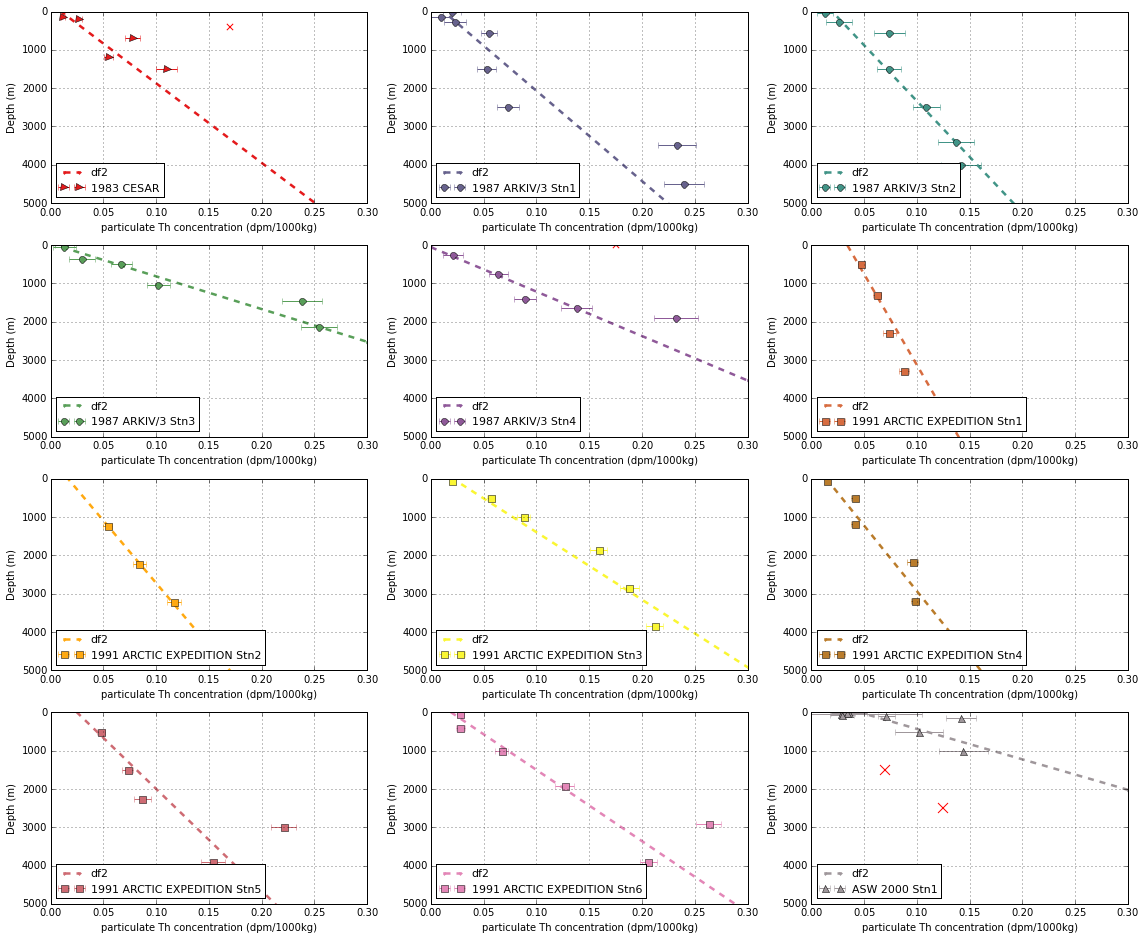

In [19]:
# Test parameterization below (Q:should we remove the deep points)

from IPython.display import Image
Image(filename='/home/xiaoxiny/Desktop/part.Th.png',width='80%') 

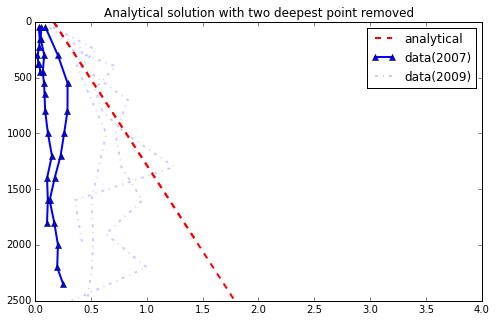

In [11]:
def analy(string,phase,i,a,b,ice):
        if string=='Th':
            k=0.1617192
            if phase=='part':
                analy=0.0267/(200)*dep[i]
            else:
                k_1=readice('deso',i,a,b)
                analy=0.0267/k+k_1/k*0.0267/(200)*dep[i]
        
        return analy

plt.title('Analytical solution with two deepest points removed')


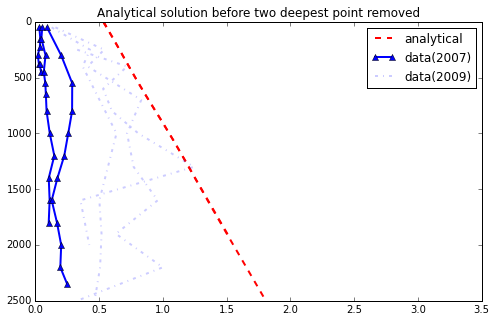

In [17]:
# parameterization in my current ANHA4 run
def analy(string,phase,i,a,b,ice):
        if string=='Th':
            k=0.05

plt.title('Analytical solution before two deepest point removed')

Fig above: k=0.1617192, s=200.9

Fig below: k=0.05     , s=1000+ 

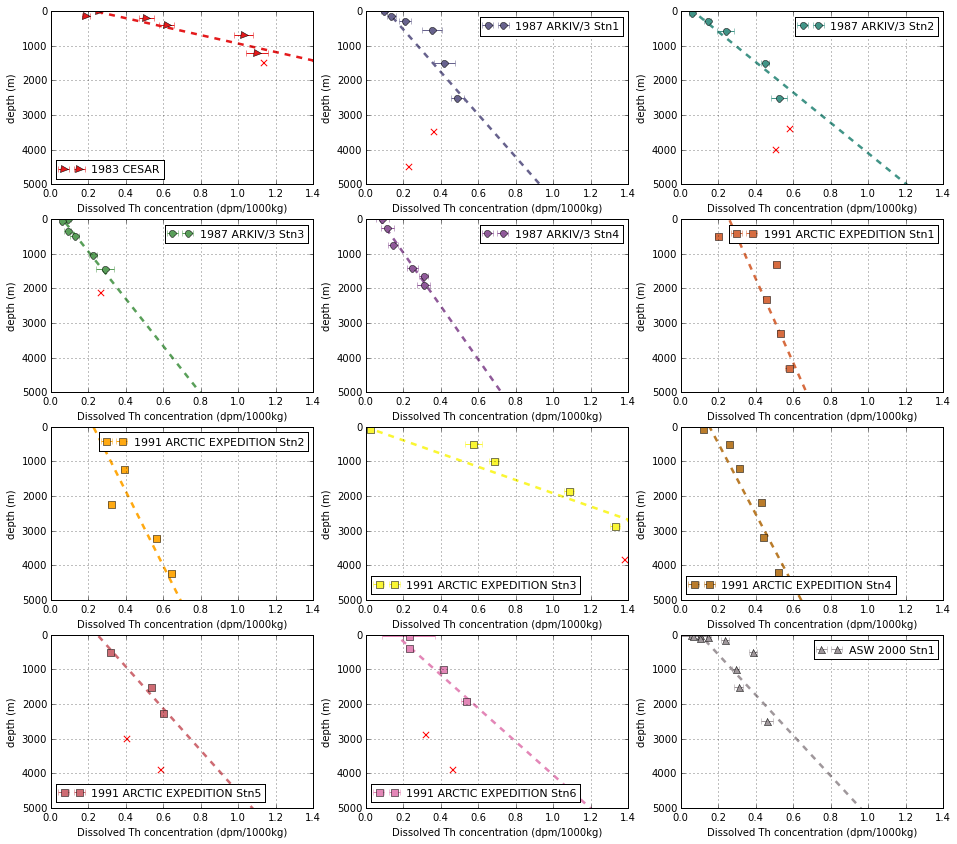

In [30]:
from IPython.display import Image
Image(filename='/home/xiaoxiny/Desktop/dissth.png',width='80%') 


Q: above shows the data we removed becaused of advection (we think). However, we don't have data to support them.

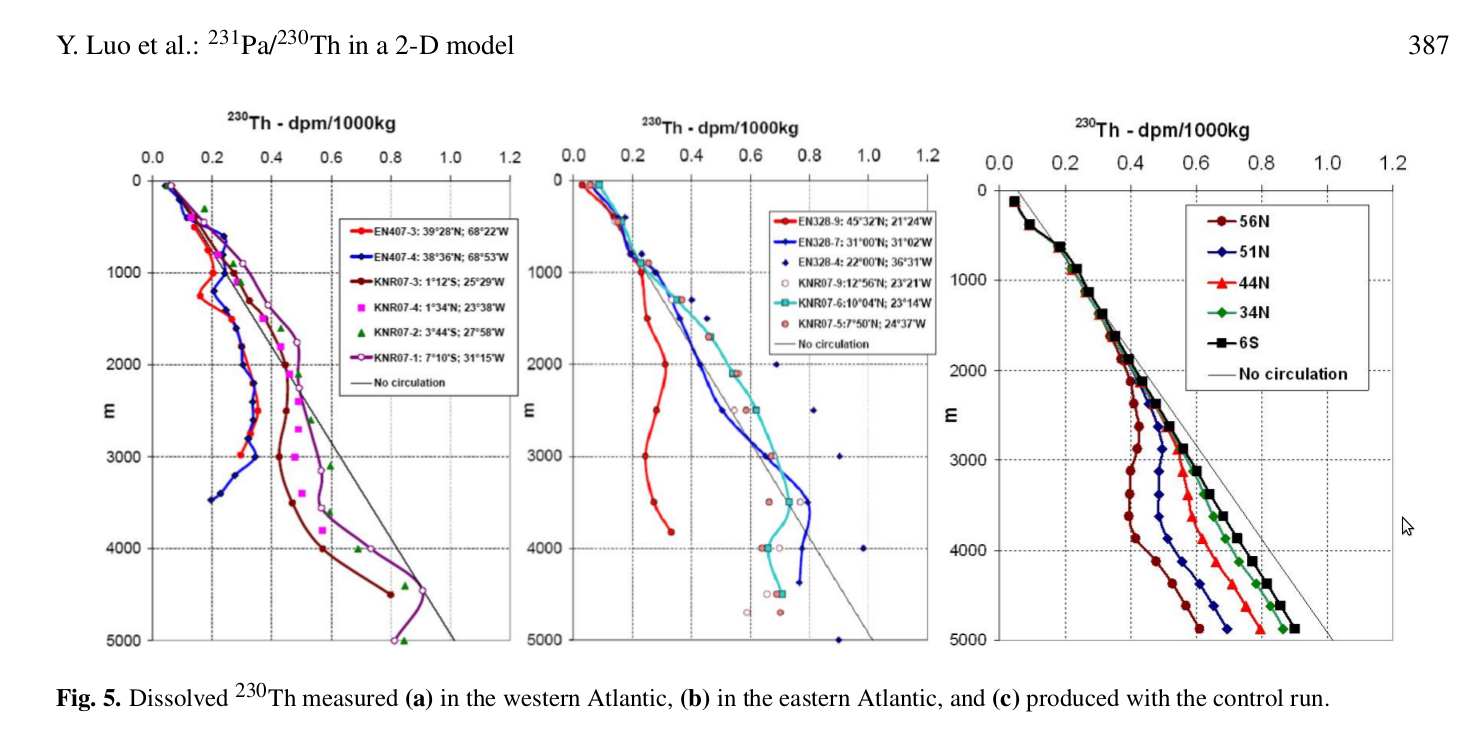

In [34]:
Image(filename='/home/xiaoxiny/Pictures/Screenshot.png',width='110%') 

## Next part: playing around with the parameters

>If the value of desorption rates are multiplied by 2,the line goes far away. If the **desorption** rates are **devided** by 2, the line is getting closer. However, this result is inconsistent with what we see on >the evalution, which wants its desorption rates to be bigger.

In [16]:
def plot_analytical(title):
    xloc=[303,302,300]
    yloc=[150,160,170]

    ax = plt.figure(1,figsize=(8,5))
    temp=0
    for k in range (len(xloc)):   
        ice=readice('Th',i=0,x=xloc[k],y=yloc[k])
        ana=np.zeros(len(data0[0,:,0,0]))
        for z in range (len(data0[0,:,0,0])):
            ana[z]   =analy('Th','diss',i=z,a=xloc[k],b=yloc[k],ice=ice[-5,:])\
                     +analy('Th','part',i=z,a=xloc[k],b=yloc[k],ice=ice[-5,:])
        ana=np.ma.masked_where(np.ma.getmask(ice[-5,:]),ana)
        if temp==0:
            plt.plot(ana,dep,'--',lw=2,c='red',label='analytical')
            temp=1
        else:
            plt.plot(ana,dep,'--',lw=2,c='red')#,label='analytical')

    for j in range(len(nc_filename)):
        data=pd.read_csv(nc_filename[j])
        y= data['depth'].values;
        x=data['230Th tot.'].values;
        lon = data['long.'].values;
        lat = data['lat.'].values;
        #name= data['name'][0];
        y_=[];x_=[];lon_=[];lat_=[];
        for i in range (len(x)):
            if x[i]>=0:
                y_.append(y[i]);x_.append(x[i])
                lon_.append(lon[i]);lat_.append(lat[i])
        if j<3 and len(lon_)!=0:
            if j ==0:
                plt.plot(x_,y_,'-^',lw=2,c='blue',label='data(2007)')
            else:
                plt.plot(x_,y_,'-^',lw=2,c='blue')#,label='data(2007)')
        if j>=3 and len(lon_)!=0:
            if j==3:
                plt.plot(x_,y_,'-.',lw=2,c='blue',label='data(2009)',alpha=0.2) 
            else:
                plt.plot(x_,y_,'-.',lw=2,c='blue',alpha=0.2)#,label='data(2009)') 

    for i in range (8,len(data0[:,0,0,0]),12):
        plt.plot(data0[i,lmin:lmax,0,yloc[k]-150],dep[lmin:lmax],lw=0.5,label='simulation: %s yr'%((i-8)/12))

    plt.ylim([300,2500])
    plt.gca().invert_yaxis()
    plt.title('%s'%(name[0]))
    plt.legend()
    plt.show()

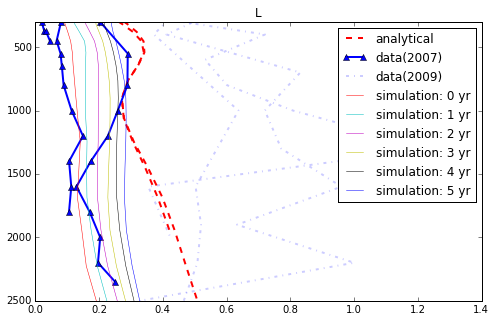

In [17]:
def analy(string,phase,i,a,b,ice):
        if string=='Th':
            k=-0.0067*100*ice[i]+0.75
            if phase=='part':
                analy=0.0267/(2.26*100*ice[i]+500)*dep[i]
            else:
                k_1=readice('deso',i,a,b)/2
                analy=0.0267/k+k_1/k*0.0267/(2.26*100*ice[i]+500)*dep[i]
        
        return analy

plot_analytical('original desoprtion rate * 0.5')

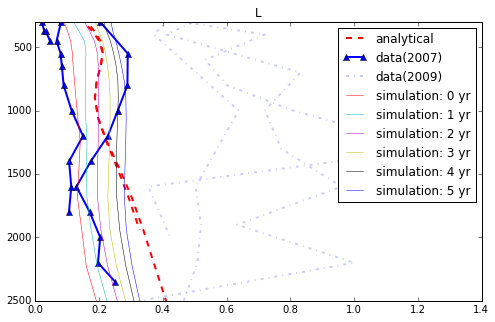

In [18]:
def analy(string,phase,i,a,b,ice):
        if string=='Th':
            k=(-0.0067*100*ice[i]+0.75)*2
            if phase=='part':
                analy=0.0267/(2.26*100*ice[i]+500)*dep[i]
            else:
                k_1=readice('deso',i,a,b)
                analy=0.0267/k+k_1/k*0.0267/(2.26*100*ice[i]+500)*dep[i]
        
        return analy



plot_analytical('original absoprtion rate *2 ')

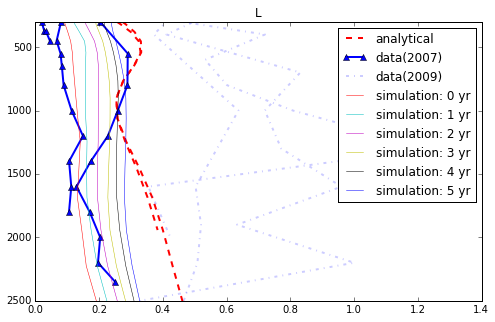

In [19]:
def analy(string,phase,i,a,b,ice):
        if string=='Th':
            k=(-0.0067*100*ice[i]+0.75)
            s=(2.26*100*ice[i]+500)*2
            if phase=='part':
                analy=0.0267/s*dep[i]
            else:
                k_1=readice('deso',i,a,b)
                analy=0.0267/k+k_1/k*0.0267/s*dep[i]
        
        return analy



plot_analytical('original sinking rate *2 ')

In [102]:
ice=readice('Th',i=0,x=303,y=150)
print ice[-52:,5]
ice=np.average(ice, axis=0)
print ice.shape
print (ice[4]*100)

[0.785929262638092 0.8543252944946289 0.9239046573638916 0.9570924043655396
 0.9807047843933105 0.9903715252876282 0.9960690140724182
 0.9564594030380249 0.9232873916625977 0.8605185747146606
 0.7652641534805298 0.36068016290664673 0.5344493389129639
 0.27994346618652344 0.9012896418571472 0.9739491939544678
 0.9902597069740295 0.9886507391929626 0.9799511432647705
 0.9743767976760864 0.9480538368225098 0.8937539458274841
 0.8382472991943359 0.6792030930519104 0.2014450877904892
 0.30932900309562683 0.9475971460342407 0.9652164578437805
 0.980721652507782 0.9903715252876282 0.9960690140724182 0.9564594030380249
 0.9232873916625977 0.8605185747146606 0.7652641534805298
 0.36068016290664673 0.5344493389129639 0.27994346618652344
 0.9012896418571472 0.9739491939544678 0.9902597069740295
 0.9886507391929626 0.9799511432647705 0.9743767976760864
 0.9480538368225098 0.8937539458274841 0.8382472991943359
 0.6792030930519104 0.2014450877904892 0.30932900309562683
 0.9475971460342407 0.96521645